In [22]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [23]:
df = pd.read_csv("C:\\Users\\My\\Desktop\\data.csv", parse_dates=['datekey'])

In [24]:
#df.sort_values('User_ID').head(10)

In [25]:
df.isna().sum()

User_ID        0
datekey        0
Usage_MB       0
age            0
gender_v       0
device_type    0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3752013 entries, 0 to 3752012
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   User_ID      int64         
 1   datekey      datetime64[ns]
 2   Usage_MB     int64         
 3   age          int64         
 4   gender_v     object        
 5   device_type  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 171.8+ MB


**Recency**

In [27]:
# having the max datekey for each user_ID and create a new data frame with it
df_max_datekey = df.groupby('User_ID').datekey.max().reset_index()
df_max_datekey.columns = ['User_ID', 'Max_datekey']
df_max_datekey

,User_ID,Max_datekey
0,2,2021-02-17
1,3,2021-01-31
2,5,2021-02-07
3,8,2021-03-01
4,9,2021-02-09
...,...,...
1144120,1659068,2021-02-26
1144121,1659069,2021-02-26
1144122,1659071,2021-02-07
1144123,1659072,2021-03-01


In [28]:
# calculating the days between the max date and the dates
# Recency is the number of days, each ID is inactive
df_max_datekey['Recency'] = (df_max_datekey['Max_datekey'].max() - df_max_datekey['Max_datekey']).dt.days
df_max_datekey[['User_ID','Recency']]

,User_ID,Recency
0,2,12
1,3,29
2,5,22
3,8,0
4,9,20
...,...,...
1144120,1659068,3
1144121,1659069,3
1144122,1659071,22
1144123,1659072,0


**Frequency**

In [29]:
df['three_weeks'] = np.nan

In [30]:
# defining 0 as the fisrt 7 days of the month and 1 as the rest of the month in the 'three_weeks' column
df['three_weeks'].loc[df['datekey'] < '2021-02-05'] = 0
df['three_weeks'].loc[df['datekey'] > '2021-02-05'] = 1

C:\Users\My\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
df_Frequency = df.groupby('User_ID').three_weeks.sum().reset_index()
df_Frequency.columns = ['User_ID','Frequency']

In [32]:
df_Frequency = df_Frequency.astype('int')
df_Frequency

,User_ID,Frequency
0,2,1
1,3,0
2,5,1
3,8,2
4,9,3
...,...,...
1144120,1659068,5
1144121,1659069,11
1144122,1659071,2
1144123,1659072,6


In [33]:
#add this data to our main dataframe
df_user = pd.merge(df_max_datekey, df_Frequency, on='User_ID')

In [34]:
df_user.drop('Max_datekey' , axis = 1 , inplace = True)

**Monetary**

In [35]:
#calculate Monetary for each user
df_Monetary = df.groupby(['User_ID','three_weeks']).Usage_MB.sum().reset_index()
#df_Monetary.columns = ['User_ID','Monetary']

In [36]:
import numpy as np
df_Monetary['Usage_MB'].loc[df_Monetary['three_weeks'] == 0] = 0

C:\Users\My\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [37]:
df_Monetary_1 = df_Monetary.groupby('User_ID').Usage_MB.sum().reset_index()
df_Monetary_1.columns = ['User_ID' , 'Monetary']

In [38]:
df_Monetary_1

,User_ID,Monetary
0,2,8
1,3,0
2,5,13
3,8,4521
4,9,5936
...,...,...
1120441,1659068,3480
1120442,1659069,11225
1120443,1659071,340
1120444,1659072,8111


In [39]:
df_user = pd.merge(df_user, df_Monetary_1, on='User_ID',)

In [40]:
df_user

,User_ID,Recency,Frequency,Monetary
0,2,12,1,8
1,3,29,0,0
2,5,22,1,13
3,8,0,2,4521
4,9,20,3,5936
...,...,...,...,...
1120441,1659068,3,5,3480
1120442,1659069,3,11,11225
1120443,1659071,22,2,340
1120444,1659072,0,6,8111


**RFM variables ranges**

In [42]:
df_user.set_index(keys = 'User_ID', inplace = True)

In [ ]:
fig , axes = plt.subplots(1,3, figsize = (20, 5))
for i , feature in enumerate (list(df_user.columns)):
    sns.distplot(df_user[feature], ax = axes[i])

In [ ]:
#statistical informations
display(df_user.describe())

**Data Normalizing**

In [43]:
scaler = MinMaxScaler()
df_user_normalized = pd.DataFrame(scaler.fit_transform(df_user))
df_user_normalized.columns = ['Recency' , 'Frequency', 'Monetary']
df_user_normalized

,Recency,Frequency,Monetary
0,0.400000,0.041667,0.000037
1,0.966667,0.000000,0.000000
2,0.733333,0.041667,0.000060
3,0.000000,0.083333,0.020960
4,0.666667,0.125000,0.027520
...,...,...,...
1120441,0.100000,0.208333,0.016134
1120442,0.100000,0.458333,0.052041
1120443,0.733333,0.083333,0.001576
1120444,0.000000,0.250000,0.037604


**K_means**

In [44]:
# applying Elbow_method to fine the accurate number of clusters
#start=dt.now()
SSE = []
for i in range(0 ,10):
    kmeans = KMeans(n_clusters = i+1 , random_state = 1231).fit(df_user_normalized)
    SSE.append(kmeans.inertia_)
#time_of_execute=dt.now()-start    
#print('time_of_execute:',time_of_execute)

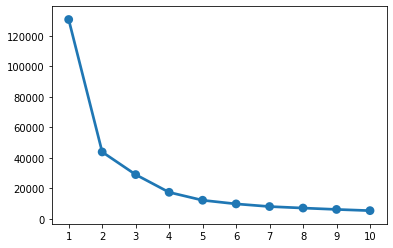

In [45]:
sns.pointplot(x = list(range(1,11)) , y = SSE)
plt.show()

# cluster = 4 or 5

In [46]:
# Applying KMeans Model
Model = KMeans(n_clusters = 4 , random_state = 1231).fit(df_user_normalized)
centers = Model.cluster_centers_

In [ ]:
from mpl_toolkits.mplot3d.axes3d import get_test_data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_user_normalized['Recency'], df_user_normalized['Frequency'], df_user_normalized['Monetary'] , cmap = 'brg'
            , c = Model.predict(df_user_normalized))
ax.scatter(centers[:, 0], centers[:, 1], c = 'black')

**Identify the clusters**

In [47]:
df_user.columns = df_user.columns

In [48]:
df_user['Cluster'] = Model.labels_

In [49]:
df_user

,Recency,Frequency,Monetary,Cluster
User_ID,,,,
2,12,1,8,0
3,29,0,0,1
5,22,1,13,1
8,0,2,4521,2
9,20,3,5936,0
...,...,...,...,...
1659068,3,5,3480,2
1659069,3,11,11225,3
1659071,22,2,340,1


In [50]:
summery_of_df_user = pd.DataFrame(df_user.groupby('Cluster').agg({
                                                                  'Recency':['mean','min', 'max'],
                                                                  'Frequency':['mean','min', 'max'],
                                                                  'Monetary':['mean','min', 'max','count']}))
summery_of_df_user["Customer_Label"] = ['Normal','Bad','Good','Excellent']
summery_of_df_user

Recency          Frequency              Monetary              \
              mean min max       mean min max          mean min     max   
Cluster                                                                   
0        14.535906  10  20   1.863589   1  10   1202.222620   1   83207   
1        24.968927  20  30   0.466312   0   3    244.912609   0   55955   
2         3.841712   0   9   2.350373   1   7   1563.328086   1  130853   
3         1.725958   0  13  11.555584   6  24  11140.454151  10  215697   

                Customer_Label  
          count                 
Cluster                         
0        320056         Normal  
1        279182            Bad  
2        424139           Good  
3         97069      Excellent

In [51]:
#creating a null column
df_user['Customer_Label'] = np.nan 

#Description of each cluster 
df_user['Customer_Label'].loc[df_user['Cluster'] == 0] = "Normal"
df_user['Customer_Label'].loc[df_user['Cluster'] == 1] = "Bad"
df_user['Customer_Label'].loc[df_user['Cluster'] == 2] = "Good"
df_user['Customer_Label'].loc[df_user['Cluster'] == 3] = "Excellent"
df_user

C:\Users\My\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Recency,Frequency,Monetary,Cluster,Customer_Label
User_ID,,,,,
2,12,1,8,0,Normal
3,29,0,0,1,Bad
5,22,1,13,1,Bad
8,0,2,4521,2,Good
9,20,3,5936,0,Normal
...,...,...,...,...,...
1659068,3,5,3480,2,Good
1659069,3,11,11225,3,Excellent
1659071,22,2,340,1,Bad


**compering with the previous RFM analysis**

In [64]:
dic_Number_of_users_in_clusters = {'Normal': len(df_user[df_user['Customer_Label'] == 'Normal']),
      'Bad':len(df_user[df_user['Customer_Label'] == 'Bad']),
      'Good' : len(df_user[df_user['Customer_Label'] == 'Good']),
      'Excellent' : len(df_user[df_user['Customer_Label'] == 'Excellent'])}

In [65]:
dic_Number_of_users_in_clusters
#three_weeks

{'Normal': 320056, 'Bad': 279182, 'Good': 424139, 'Excellent': 97069}

In [68]:
#four weeks (the previous RFM)
#{'Normal': 346053, 'Bad': 305483, 'Good': 399804, 'Excellent': 92785}

In [66]:
# finding inactive users
i_U =  df_user[df_user['Customer_Label'] == 'Bad']
inactive_Users = i_U[i_U['Frequency'] == 0]
len(inactive_Users)
#inactive_Users

168952